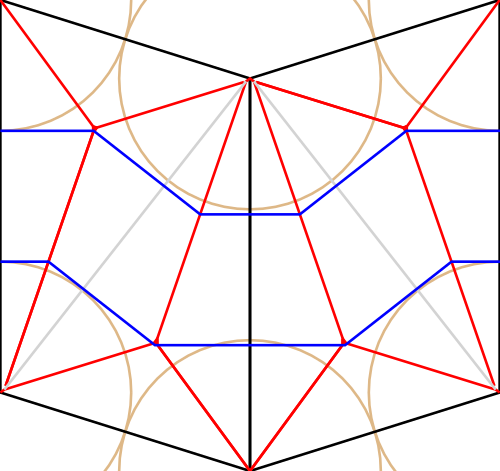

In [33]:
##### from sympy import *
#from sympy.plotting import plot
import networkx as nx
import numpy as np
import drawSvg as draw
import time
from itertools import count
from shapely.geometry import Polygon, Point, MultiPoint, LineString, MultiLineString
from shapely.geometry.polygon import orient
from shapely.ops import split, linemerge, nearest_points
from shapely.affinity import rotate, translate

circle_color = "#DEB887"
river_color = "blue"
crease_color = "red"
guide_color = "lightgrey"
polygon_color = "black"
precision = 1
scale = 100
line_thickness = 10
viewport = 500
step = 1
epsilon = 0.1
def max_val (points,x=0, y=0):
    for point in points: 
        if point.x > x: x = point.x
        if point.y > y: y = point.y
    return float(x),float(y)
def draw_poly(p,d, col):
    path = draw.Path(stroke=col, stroke_width=line_thickness/viewport*scale, fill='none')
    path.M(p[0][0], p[0][1]) #point is a tuple (x,y)
    [path.L(v[0],v[1]) for v in p]
    d.append(path)
    
def render(points,circles,creases,guides,polys, rivers):
    w,h = max_val(points)
    d = draw.Drawing (w,h)
    for c in circles:  draw_poly(c.exterior.coords,d,circle_color)
    for p in lang_polys: draw_poly(p.exterior.coords,d,polygon_color)
    for crease in creases: draw_poly(crease.coords,d,crease_color)
    for g in guides: draw_poly(g.coords,d,guide_color)
    for r in rivers: draw_poly(r.coords,d, river_color)
    d.setRenderSize(viewport,viewport*h/w)
    d.saveSvg("export.svg")
    return d

def point_from_id(index, ids): return next((point for point, i in ids.items() if i == index), None)
def shrink_polygon(polygon,sweep_length,ids,d,active,creases,guides):
    # shrink the polygon    
    shrunk_poly = polygon.buffer(sweep_length*-1) 

    # look for contraction events
    if shrunk_poly.is_empty:
        for p1 in polygon.exterior.coords:        # connect all remaining creases to one another
            for p2 in polygon.exterior.coords:
                if (Point(p1).distance(Point(p2))>2*sweep_length):
                    extend_creases(creases,LineString([p1,p2]))
        return                                    # stop recursive calling of shrink_polygon
    
    # look for split events
    if len(polygon.exterior.coords) > 4:          # ignore triangles as no split event can happen here
        a = np.where(active == 1)                 # find the active paths
        for i in range(len(a[0])):
            cut_path = LineString([point_from_id(a[0][i],ids),point_from_id(a[1][i],ids)])
            if Point(cut_path.coords[0]).distance(Point(cut_path.coords[1]))-d[ids[cut_path.coords[0]]][ids[cut_path.coords[1]]] < epsilon:
                guides.append(cut_path)
                split_1,split_2 = split(polygon, cut_path)
                shrink_polygon(split_1,sweep_length,ids.copy(),d,get_active_paths(split_1,ids, d),creases,guides)
                shrink_polygon(split_2,sweep_length,ids.copy(),d,get_active_paths(split_2,ids, d),creases,guides)
                return
            
    # generate creases        
    for i,p in enumerate(polygon.exterior.coords):
        extend_creases(creases,LineString([p,shrunk_poly.exterior.coords[i]]))
        if i>0: ids[shrunk_poly.exterior.coords[i]] = ids.pop(p)

    # recursively call the shrinking with the new polygon
    shrink_polygon(shrunk_poly,sweep_length,ids,d,active,creases,guides)
    
def extend_creases(creases,extension):
    for i,crease in enumerate(creases):
        if extension.touches(crease):
            merge = linemerge(MultiLineString([extension,crease]))
            if type(merge) == LineString: creases[i] = merge
            return
    creases.append(extension)       
    
def tree_method(polygons,sweep_length,ids,d,creases,guides):
    for polygon in polygons:
        active_paths = get_active_paths(polygon,ids, d)
        # set "markers" on the 0 edges that require more than 2 nodes to traverse
        shrink_polygon(polygon,sweep_length,ids.copy(),d,active_paths,creases,guides)
        
def get_active_paths(polygon,ids,d):
    paths = np.zeros((len(ids),len(ids)))
    for p1 in polygon.exterior.coords:
        for p2 in polygon.exterior.coords:
            if ids[p1] > ids[p2]:
                if  abs(Point(p1).distance(Point(p2))-d[ids[p1]][ids[p2]]) > epsilon:
                    paths[ids[p1]][ids[p2]] = 1

    return paths

def river_from_line(line,creases, rivers, width):
    ref = float('inf')
    start = Point(line.coords[0])
    intersecting_crease =  river = None
    for j,crease in enumerate(creases):
        intersection = line.intersection(crease)
        if not intersection.is_empty:
            if type(intersection) == Point: intersection = [intersection]
            for point in intersection:
                river_candidate = LineString([start,point])
                if river_candidate.length < ref and river_candidate.length>epsilon: 
                    ref = river_candidate.length
                    river = river_candidate
                    intersecting_crease = crease
                    
    if river == None:
        extend_creases(rivers,line)
        rivers.append(rivers[-1].parallel_offset(width/2,'left',join_style=2))
        rivers.append(rivers[-2].parallel_offset(width/2,'right',join_style=2))
        rivers.remove(rivers[-3])
        return
    intersection_point = Point(river.coords[1])
    circle = intersection_point.buffer(0.1)
    line_slope = azimuth(start,intersection_point)
    crease_slope = azimuth(Point(intersecting_crease.intersection(circle).coords[0]),intersection_point)
    line = rotate(line, 180+2*(line_slope - crease_slope), origin=intersection_point)
    line = translate(line, intersection_point.x- line.coords[0][0],intersection_point.y - line.coords[0][1] )
    extend_creases(rivers,river)
    river_from_line(line,creases,rivers, width)

def azimuth(point1, point2):
    angle = np.arctan2(point2.x - point1.x, point2.y - point1.y)
    return np.degrees(angle) if angle >= 0 else np.degrees(angle) + 360

#TODO: do the actual NLopt for circle packing
raw_points = Point(0,0.6), Point(0,3.6), Point(1.908,0),Point(1.908,3), Point(3.816,0.6), Point(3.816,3.600)
points = [Point(p.x*scale,p.y*scale) for p in raw_points]
point_ids = {}
set_id = count()
T = nx.Graph()
for p in points:
    point_ids[p.coords[0]] = next(set_id)
    T.add_node(point_ids[p.coords[0]], pos=points)
inner_node1 = next(set_id)
inner_node2 = next(set_id)    

T.add_node(inner_node1)
T.add_node(inner_node2)
T.add_edge(0,inner_node2,weight=1*scale)
T.add_edge(1,inner_node1,weight=1*scale)
T.add_edge(2,inner_node2,weight=1*scale)
T.add_edge(3,inner_node1,weight=1*scale)
T.add_edge(4,inner_node2,weight=1*scale)
T.add_edge(5,inner_node1,weight=1*scale)
T.add_edge(inner_node1,inner_node2,weight=1*scale)
d = {x[0]:x[1] for x in nx.all_pairs_dijkstra_path_length(T)}   


# TODO: make the size of circles the length in the tree
circles = [point.buffer(1*scale) for point in points]


#TODO figure out again where the polygons come from
lang_polys = [Polygon(MultiPoint(points[:4]).convex_hull),Polygon(MultiPoint(points[2:]).convex_hull)] #convex hull guarantees the right orientation of the points


creases, guides, rivers = [],[],[]
tree_method(lang_polys,step,point_ids.copy(),d,creases,guides)

l = LineString([Point(0,2.1*scale), Point(5*scale,2.1*scale)])
river_from_line(l,creases, rivers, 1*scale)
render(points,circles,creases,guides,lang_polys,rivers)


